### MP: SVanalyzer

* The following notebook is trained on data generated from revised R script [Oct 12 2017]
    * Exact Match [1] and Homozygous [0] Reference data points
    * Removed all data points with Gtcons and GTconswithoutXX -1
* 5k randomly selected deletions test data was also processed through same R script
* Balanced Training Set for GTcons labels:
    * 194 Hom Var
    * 200 Hom Ref
    * 200 Het Var
* **Train/Prediction Label:** EM, HR, IC

In [1]:
"""
Imports
"""
import pandas as pd
import numpy as np
from fancyimpute import KNN
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LeaveOneOut
from scipy.stats import ks_2samp
from scipy import stats
from matplotlib import pyplot
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA as sklearnPCA
import plotly.plotly as py
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score
from sklearn import preprocessing
from ggplot import *
from bokeh.models import HoverTool
from bokeh.plotting import show
from bokeh.charts import Scatter, Histogram, output_file, show
from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.charts import Bar, output_file, show
import bokeh.palettes as palettes
from bokeh.models import HoverTool, BoxSelectTool, Legend
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

In [2]:
# Import Training Data
# SVanalyzer generated training data
df_train = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/MP_EM_HR_IC_HG002_DEL_min1.csv')
df_train_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/training_data/tech_sep/HG002/DEL/MP_EM_HR_IC_HG002_DEL_min1.csv')
df_train.rename(columns={'size': 'Size'}, inplace=True)
df_train.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,HG002,23,72766323,72811839,-45516,Deletion,Deletion,0,0,...,37.0,0.0,407.258016,75.825041,1341.0,6772.969426,1134.257283,1341.0,0.0,0.0


In [3]:
# Import Test Data
# SVanalyzer generated training data
df_test = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/MP_HG002_DEL_min1.csv')
df_test_2 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/dataframes/test/final_df/tech_sep/DEL/HG002/MP_HG002_DEL_min1.csv')
df_test.rename(columns={'size': 'Size'}, inplace=True)
df_test.head(1)

,chrom,sample,id,start,end,Size,type,SVtype,refN_cnt,refN_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,HG002,859,37568322,37568587,-115,Insertion,Deletion,0,0,...,43.0,456.0,411.08,53.348604,25.0,6586.56,999.928961,15.0,0.0,10.0


In [4]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(c) - set(d)

{'Label'}

In [5]:
### Drop columns that are not shared by both dataframes
df_train.drop(['GTconswithoutIllMP.GT'], axis=1, inplace = True)
df_train.drop(['GTcons'], axis=1, inplace = True)
df_train.drop(['GTconflict'], axis=1, inplace = True)
df_train.drop(['GTsupp'], axis=1, inplace = True)
df_train.drop(['sample'], axis=1, inplace = True)
df_train.drop(['SVtype'], axis=1, inplace = True)
df_train.drop(['type'], axis=1, inplace = True)
df_train.drop(['id'], axis=1, inplace = True)

In [6]:
df_train.head(1)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,37.0,0.0,407.258016,75.825041,1341.0,6772.969426,1134.257283,1341.0,0.0,0.0


In [7]:
df_train['chrom'].replace('X', 23, inplace=True)
df_train['chrom'].replace('Y', 24, inplace=True)
df_test['chrom'].replace('X', 23, inplace=True)
df_test['chrom'].replace('Y', 24, inplace=True)

In [8]:
# Store header names in lists and find names that are NOT contained in BOTH lists
c = list(df_train.columns.values)
d = list(df_test.columns.values)
set(d) - set(c)

{'GTconflict',
 'GTcons',
 'GTconswithoutIllMP.GT',
 'GTsupp',
 'SVtype',
 'id',
 'sample',
 'type'}

In [9]:
### Drop columns that are not shared by both dataframes
df_test.drop(['GTconswithoutIllMP.GT'], axis=1, inplace = True)
df_test.drop(['GTcons'], axis=1, inplace = True)
df_test.drop(['GTconflict'], axis=1, inplace = True)
df_test.drop(['GTsupp'], axis=1, inplace = True)
df_test.drop(['sample'], axis=1, inplace = True)
df_test.drop(['SVtype'], axis=1, inplace = True)
df_test.drop(['type'], axis=1, inplace = True)
df_test.drop(['id'], axis=1, inplace = True)

***
Impute missing values using KNN
***

In [10]:
# Store training data in a new variable which will be converted to a matrix
X = df_train
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1,72766323,72811839,-45516,0,0,4,0.076523,110,0.059979,...,37.0,0.0,407.258016,75.825041,1341.0,6772.969426,1134.257283,1341.0,0.0,0.0
1,1,96139975,96142391,-2416,0,0,0,0.000000,2,0.014487,...,42.0,175.0,414.641177,73.834278,170.0,6312.523529,1009.050877,118.0,52.0,0.0
2,1,109690878,109690918,-39,0,0,0,0.000000,1,0.400000,...,35.0,396.0,474.000000,40.447497,4.0,7461.000000,757.261514,3.0,0.0,1.0


In [11]:
# Convert dataframe to matrix
X=X.as_matrix()

#Imput missing values from three closest observations
X_imputed=KNN(k=3).complete(X)
X=pd.DataFrame(X_imputed)

Imputing row 1/2543 with 1 missing, elapsed time: 2.134
Imputing row 101/2543 with 1 missing, elapsed time: 2.183
Imputing row 201/2543 with 1 missing, elapsed time: 2.188
Imputing row 301/2543 with 1 missing, elapsed time: 2.193
Imputing row 401/2543 with 1 missing, elapsed time: 2.199
Imputing row 501/2543 with 1 missing, elapsed time: 2.204
Imputing row 601/2543 with 1 missing, elapsed time: 2.209
Imputing row 701/2543 with 1 missing, elapsed time: 2.214
Imputing row 801/2543 with 1 missing, elapsed time: 2.220
Imputing row 901/2543 with 1 missing, elapsed time: 2.228
Imputing row 1001/2543 with 1 missing, elapsed time: 2.234
Imputing row 1101/2543 with 1 missing, elapsed time: 2.238
Imputing row 1201/2543 with 1 missing, elapsed time: 2.245
Imputing row 1301/2543 with 1 missing, elapsed time: 2.249
Imputing row 1401/2543 with 1 missing, elapsed time: 2.255
Imputing row 1501/2543 with 1 missing, elapsed time: 2.260
Imputing row 1601/2543 with 1 missing, elapsed time: 2.265
Imputing 

In [12]:
# Store header values in a list, will be used later to re-label the matrix post KNN imputation
dftrain_header = list(df_train.columns.values)
X.columns = dftrain_header
X.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,72766323.0,72811839.0,-45516.0,0.0,0.0,4.0,0.076523,110.0,0.059979,...,37.0,0.0,407.258016,75.825041,1341.0,6772.969426,1134.257283,1341.0,0.0,0.0
1,1.0,96139975.0,96142391.0,-2416.0,0.0,0.0,0.0,0.000000,2.0,0.014487,...,42.0,175.0,414.641177,73.834278,170.0,6312.523529,1009.050877,118.0,52.0,0.0
2,1.0,109690878.0,109690918.0,-39.0,0.0,0.0,0.0,0.000000,1.0,0.400000,...,35.0,396.0,474.000000,40.447497,4.0,7461.000000,757.261514,3.0,0.0,1.0


In [13]:
# Store Labels in a new 'Y' DataFrame
Y = pd.DataFrame()
Y = X['Label']

In [14]:
#Count the number of labels
pd.value_counts(Y.values, sort=False)

1.0    823
0.0    969
2.0    751
dtype: int64

In [15]:
# Note: originally selected 1000 of each label --> find out why some are lost

In [16]:
# Remove labels from feature set
X.drop(['Label'],axis=1, inplace = True)

In [17]:
# Order features
X4 = X.reindex_axis(sorted(X.columns), axis=1)

***
Machine Learning
***

<a id='machine_learning'></a>

Description:

   * In the following section a random forest model will be trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_1)
       * The model was trained using [train/test split](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model will be used to predict labels for 5000 randomly selected deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_1'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
    

** Train Random Forest Classifier **

<a id='train_test'></a>

In [18]:
# Train Test Split
# Train on 70% of the data and test on 30%
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size=0.3, random_state=0)

In [19]:
# Train Random Forest Classifier
model = RandomForestClassifier() 
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [20]:
# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.077074)
2. feature 4 (0.075893)
3. feature 6 (0.074073)
4. feature 32 (0.061519)
5. feature 2 (0.049015)
6. feature 26 (0.039482)
7. feature 24 (0.037929)
8. feature 16 (0.034142)
9. feature 23 (0.033932)
10. feature 29 (0.031744)
11. feature 19 (0.029650)
12. feature 14 (0.029636)
13. feature 12 (0.029328)
14. feature 9 (0.028103)
15. feature 13 (0.027564)
16. feature 11 (0.027159)
17. feature 25 (0.026428)
18. feature 39 (0.026114)
19. feature 34 (0.025843)
20. feature 27 (0.025782)
21. feature 10 (0.024531)
22. feature 28 (0.022874)
23. feature 41 (0.022776)
24. feature 22 (0.021350)
25. feature 5 (0.018922)
26. feature 40 (0.018538)
27. feature 33 (0.018451)
28. feature 3 (0.012863)
29. feature 38 (0.012373)
30. feature 37 (0.009113)
31. feature 20 (0.007761)
32. feature 7 (0.007596)
33. feature 30 (0.005288)
34. feature 31 (0.002488)
35. feature 15 (0.002381)
36. feature 0 (0.002007)
37. feature 8 (0.000278)
38. feature 17 (0.000000)
39. feature 18

<a id='feature_importance'></a>

/Users/lmc2/anaconda/envs/NIHFAES/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



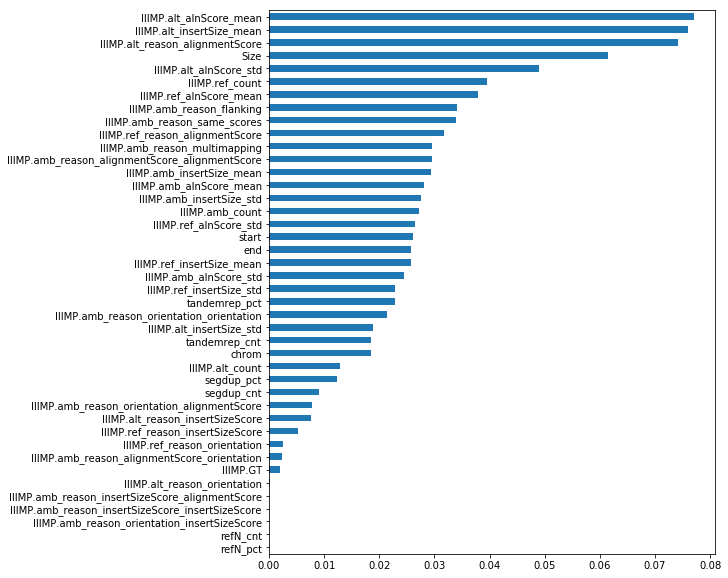

In [21]:
%matplotlib inline
feature_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(8,10))

In [22]:
#NOTE: Training Set - Show number of Hom Ref, Hom Var, Het Var datapoints the model was trained on
ytrain = pd.DataFrame()
ytrain['ytrain'] = y_train
pd.value_counts(ytrain['ytrain'].values, sort=False)

0.0    674
2.0    524
1.0    582
dtype: int64

In [23]:
pred = model.predict(X_test)

<a id='traintest_precision'></a>

In [24]:
precision_score(pred, y_test, average='micro') 

0.73132372214941022

In [25]:
# Add original labels and predicted labels back to the original dataframe
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head()

,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,IllMP.alt_insertSize_mean,IllMP.alt_insertSize_std,IllMP.alt_reason_alignmentScore,IllMP.alt_reason_insertSizeScore,IllMP.alt_reason_orientation,IllMP.amb_alnScore_mean,...,Size,chrom,end,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
2062,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357.722862,...,-55.0,18.0,35315727.0,0.0,0.0,0.0,0.0,35315660.0,1.0,0.044776
480,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,358.830970,...,-24.0,3.0,153019165.0,0.0,0.0,0.0,0.0,153019140.0,2.0,0.840000
2044,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,355.094702,...,-145.0,17.0,48244154.0,0.0,0.0,0.0,0.0,48244009.0,4.0,0.496552
883,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,354.812979,...,-199.0,10.0,9315218.0,0.0,0.0,0.0,0.0,9315019.0,1.0,1.000000
2450,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.262003,...,-439.0,7.0,155201321.0,0.0,0.0,0.0,0.0,155199593.0,1.0,0.009838


In [26]:
labels = pd.DataFrame(y_test)

In [27]:
df_Xtest['predicted_label'] = pred
df_Xtest['Label'] = df_train['Label']
df_Xtest['chrom'] = df_train['chrom']
df_Xtest['start'] = df_train['start']
df_Xtest['end'] = df_train['end']
# df_Xtest['Y_test'] = labels

In [28]:
pd.value_counts(df_Xtest['Label'].values, sort=False)

0    295
1    241
2    227
dtype: int64

In [29]:
pd.value_counts(df_Xtest['predicted_label'].values, sort=False)

0.0    338
2.0    170
1.0    255
dtype: int64

In [30]:
from sklearn.metrics import confusion_matrix
ytest = df_Xtest['Label']
predict = df_Xtest['predicted_label']
print(confusion_matrix(ytest, predict))

[[245  15  35]
 [ 25 197  19]
 [ 68  43 116]]


In [31]:
df_Xtest['Label'].replace(0, 'Homozygous_Reference', inplace=True)
df_Xtest['Label'].replace(1, 'Exact_Match', inplace=True)
df_Xtest['Label'].replace(2, 'Inaccurate_Call', inplace=True)
df_Xtest['predicted_label'].replace(0.0, 'Homozygous_Reference', inplace=True)
df_Xtest['predicted_label'].replace(1.0, 'Exact_Match', inplace=True)
df_Xtest['predicted_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

<a id='traintest_confusion_matrix'></a>

In [32]:
pd.crosstab(ytest, predict, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,Exact_Match,Homozygous_Reference,Inaccurate_Call,All
True,,,,
Exact_Match,197,25,19,241
Homozygous_Reference,15,245,35,295
Inaccurate_Call,43,68,116,227
All,255,338,170,763


In [33]:
from sklearn.metrics import classification_report
print(classification_report(predict,ytest))

                      precision    recall  f1-score   support

         Exact_Match       0.82      0.77      0.79       255
Homozygous_Reference       0.83      0.72      0.77       338
     Inaccurate_Call       0.51      0.68      0.58       170

         avg / total       0.75      0.73      0.74       763



***
Predict
***

Description:

   * In the [previous section](#machine_learning) the model was trained on svanalyzer data.
   **FYI**: [see description below of the SVanalyzer data](#svan_2)
       * The model was trained using [train/test split](#train_test) where 70% of the data was used to train the model and the model performance was determined by predicting labels for the remaining 30% of the data
       * Reminder: The labels for this training set and the following [prediction step](#prediction_step) are:
           * Exact Match (1)
           * Homozygous Reference (0)
           * Inaccurate Call (2)
           
   * The trained model is used in the following section to predict labels for 5000 randomly selected Deletions [these datapoints were randomly selected from [union_170509_refalt.sort.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/)]
   
   

<a id='svan_2'></a>
* **Reminder - SVanalyzer data description:** 
     * **1000 Exact Match**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Homozygous Reference**: 1000 datapoints were randomly selected from the following [svanalyzer_union_170509_v0.3.0b.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
     * **1000 Inaccurate Calls**: 1000 datapoints were randomly selected from the following
[svanalyzer_union_170509_refalt.2.2.2.clustered.uniquecalls.vcf](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_UnionSVs_05092017/Preliminary_Integrations_v0.3.0/)
   
   * Source of Features: svviz, GA4GH [tandem repeat, segmental duplications, refN], R analysis [consensus genotype, GTsup]   
   

** Load Data **

In [34]:
X2 = df_test

** Impute missing values using KNN **

In [35]:
#Convert dataframe to matrix
X2=X2.as_matrix()

#Imput missing values from three closest observations
X2_imputed=KNN(k=3).complete(X2)
X2=pd.DataFrame(X2_imputed)

Imputing row 1/4030 with 1 missing, elapsed time: 5.146
Imputing row 101/4030 with 1 missing, elapsed time: 5.152
Imputing row 201/4030 with 1 missing, elapsed time: 5.158
Imputing row 301/4030 with 1 missing, elapsed time: 5.164
Imputing row 401/4030 with 1 missing, elapsed time: 5.170
Imputing row 501/4030 with 1 missing, elapsed time: 5.176
Imputing row 601/4030 with 1 missing, elapsed time: 5.184
Imputing row 701/4030 with 1 missing, elapsed time: 5.191
Imputing row 801/4030 with 1 missing, elapsed time: 5.200
Imputing row 901/4030 with 2 missing, elapsed time: 5.212
Imputing row 1001/4030 with 2 missing, elapsed time: 5.223
Imputing row 1101/4030 with 2 missing, elapsed time: 5.235
Imputing row 1201/4030 with 2 missing, elapsed time: 5.247
Imputing row 1301/4030 with 2 missing, elapsed time: 5.259
Imputing row 1401/4030 with 2 missing, elapsed time: 5.271
Imputing row 1501/4030 with 2 missing, elapsed time: 5.284
Imputing row 1601/4030 with 2 missing, elapsed time: 5.302
Imputing 

In [36]:
dftest_header = list(df_test.columns.values)
X2.columns = dftest_header
X2.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.0,3.0,0.818868,...,43.0,456.0,411.080000,53.348604,25.0,6586.560000,999.928961,15.0,0.0,10.0
1,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,34.0,345.0,370.000000,0.000000,1.0,4426.000000,0.000000,1.0,0.0,0.0
2,1.0,2629212.0,2629373.0,-160.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,104.0,111.0,392.192308,77.179620,26.0,5318.038462,2166.320853,25.0,0.0,1.0


In [37]:
X3 = pd.DataFrame()
X3 = X2
X3.head(3)

,chrom,start,end,Size,refN_cnt,refN_pct,segdup_cnt,segdup_pct,tandemrep_cnt,tandemrep_pct,...,IllMP.amb_reason_orientation_orientation,IllMP.amb_reason_same_scores,IllMP.ref_alnScore_mean,IllMP.ref_alnScore_std,IllMP.ref_count,IllMP.ref_insertSize_mean,IllMP.ref_insertSize_std,IllMP.ref_reason_alignmentScore,IllMP.ref_reason_insertSizeScore,IllMP.ref_reason_orientation
0,1.0,37568322.0,37568587.0,-115.0,0.0,0.0,0.0,0.0,3.0,0.818868,...,43.0,456.0,411.080000,53.348604,25.0,6586.560000,999.928961,15.0,0.0,10.0
1,1.0,1092675.0,1092715.0,-40.0,0.0,0.0,0.0,0.0,1.0,1.000000,...,34.0,345.0,370.000000,0.000000,1.0,4426.000000,0.000000,1.0,0.0,0.0
2,1.0,2629212.0,2629373.0,-160.0,0.0,0.0,1.0,1.0,0.0,0.000000,...,104.0,111.0,392.192308,77.179620,26.0,5318.038462,2166.320853,25.0,0.0,1.0


In [38]:
# Order features
X5 = X2.reindex_axis(sorted(X2.columns), axis=1)

<a id='prediction_step'></a>

In [39]:
pred = model.predict(X5)

In [40]:
pred_prob = model.predict_proba(X5)

In [41]:
X5['predicted_label'] = pred
X5['chrom'] = df_test_2['chrom']
X5['start'] = df_test_2['start']
X5['end'] = df_test_2['end']
X5['Size'] = df_test_2['Size']
X5['GTcons'] = df_test_2['GTcons']
X5['GTsupp'] = df_test_2['GTsupp']
X5['GTconswithoutIllMP.GT'] = df_test_2['GTconswithoutIllMP.GT']

In [42]:
X6 = pd.concat([X5, pd.DataFrame(pred_prob, columns=['1','2','3'])])

In [43]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/MP_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

In [ ]:
#Note: Reformat X6 csv

In [44]:
X6 = pd.read_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/preliminary_df/MP_pred_prob_DEL_SVanalyzer_revised_EMHRIC.csv')

In [45]:
X6.rename(columns={'1': 'Homozygous_Reference_SVan_predprob_MP'}, inplace=True)
X6.rename(columns={'2': 'Exact_Match_predprob_MP'}, inplace=True)
X6.rename(columns={'3': 'Inaccurate_Call_predprob_MP'}, inplace=True)
X6.rename(columns={'predicted_label': 'MP_predicted_EMHRIC_label'}, inplace=True)

In [46]:
X6.head(3)

,Homozygous_Reference_SVan_predprob_MP,Exact_Match_predprob_MP,Inaccurate_Call_predprob_MP,GTcons,GTconswithoutIllMP.GT,GTsupp,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,...,chrom,end,MP_predicted_EMHRIC_label,refN_cnt,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct
0,0.6,0.1,0.3,0,0,4,-1.0,0.0,0.0,0.0,...,1,37568587,0,0,0,0,0.0,37568322,3,0.818868
1,0.3,0.5,0.2,1,1,1,-1.0,488.0,0.0,1.0,...,1,1092715,1,0,0,0,0.0,1092675,1,1.000000
2,0.2,0.3,0.5,0,0,1,-1.0,472.0,0.0,1.0,...,1,2629373,2,0,0,1,1.0,2629212,0,0.000000


In [47]:
X6.to_csv('/Volumes/lesleydata/SVanalyzer_ML/Oct122017_Revised_R/summary_plots/data/MP_final_df_DEL_SVanalyzer_revised_EMHRIC.csv', index=False)

***
Label Analysis
***

Description:
  * Comparison of model predicted labels [Exact Match, Homozygous Reference, Inaccurate Calls] to consensus genotype for the 5000 randomly selected datapoints from union_refalt.vcf for HG002 only

In [48]:
from sklearn.metrics import confusion_matrix
consensus_GT = X6['GTcons']
predict = X6['MP_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 582   73  224]
 [ 204 1769  267]
 [  16  831   64]]


In [49]:
from sklearn.metrics import confusion_matrix
GT_without_XX = X6['GTconswithoutIllMP.GT']
predict = X6['MP_predicted_EMHRIC_label']
print(confusion_matrix(consensus_GT, predict))

[[ 582   73  224]
 [ 204 1769  267]
 [  16  831   64]]


In [50]:
pd.value_counts(X6['GTconswithoutIllMP.GT'].values, sort=False)

0     879
2     911
1    2240
dtype: int64

In [51]:
pd.value_counts(X6['GTcons'].values, sort=False)

0     879
2     911
1    2240
dtype: int64

In [52]:
X6['GTcons'].replace(-1, 'Unknown', inplace=True)
X6['GTcons'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTcons'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTcons'].replace(2, 'Homozygous_Variant', inplace=True)
X6['MP_predicted_EMHRIC_label'].replace(0.0, 'Homozygous_Reference_SVan', inplace=True)
X6['MP_predicted_EMHRIC_label'].replace(1.0, 'Exact_Match', inplace=True)
X6['MP_predicted_EMHRIC_label'].replace(2.0, 'Inaccurate_Call', inplace=True)

In [54]:
X6['GTconswithoutIllMP.GT'].replace(-1, 'Unknown', inplace=True)
X6['GTconswithoutIllMP.GT'].replace(0, 'Homozygous_Reference', inplace=True)
X6['GTconswithoutIllMP.GT'].replace(1, 'Heterozygous_Variant', inplace=True)
X6['GTconswithoutIllMP.GT'].replace(2, 'Homozygous_Variant', inplace=True)

<a id='svan_gtcons'></a>

** Compare SVanalyzer Labels to GTcons **

In [55]:
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,1769,204,267,2240
Homozygous_Reference,73,582,224,879
Homozygous_Variant,831,16,64,911
All,2673,802,555,4030


** Compare SVanalyzer Labels to LOO Consensus GT **

In [56]:
pd.crosstab(GT_without_XX, predict, rownames=['GTcons_withoutXX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_withoutXX,,,,
Heterozygous_Variant,1769,204,267,2240
Homozygous_Reference,73,582,224,879
Homozygous_Variant,831,16,64,911
All,2673,802,555,4030


** High Confidence Label Analysis**
* **Reminder:** The labels predicted by the model are the following svanalyzer labels:
    * Homozygous Reference: 0 
    * Exact Match: 1 
    * Inaccurate Call: 2 
* Here **high confidence labels** are the labels predicted by the model that were also assigned a predict probability of either 0.9 or 1
* The following is an analysis of predicted svanalyzer labels with predict probability >0.9

In [57]:
high_conf_labels = X6[(X6['Homozygous_Reference_SVan_predprob_MP'] == 1) | (X6['Homozygous_Reference_SVan_predprob_MP'] == 0.9) | (X6['Exact_Match_predprob_MP'] == 1) | (X6['Exact_Match_predprob_MP'] == 0.9) | (X6['Inaccurate_Call_predprob_MP'] == 1) | (X6['Inaccurate_Call_predprob_MP'] == 0.9)]

** Consensus Genotype versus SVanalyzer Labels **

In [58]:
consensus_GT = high_conf_labels['GTcons']
predict = high_conf_labels['MP_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons,,,,
Heterozygous_Variant,745,19,31,795
Homozygous_Reference,4,138,13,155
Homozygous_Variant,516,1,7,524
All,1265,158,51,1474


** LOO Genotype versus SVanalyzer Labels **

In [59]:
consensus_GT = high_conf_labels['GTconswithoutIllMP.GT']
predict = high_conf_labels['MP_predicted_EMHRIC_label']
pd.crosstab(consensus_GT, predict, rownames=['GTcons_without_XX'], colnames=['SVanalyzer_Label'], margins=True)

SVanalyzer_Label,Exact_Match,Homozygous_Reference_SVan,Inaccurate_Call,All
GTcons_without_XX,,,,
Heterozygous_Variant,745,19,31,795
Homozygous_Reference,4,138,13,155
Homozygous_Variant,516,1,7,524
All,1265,158,51,1474


***
Graphs
***

** Exact Match **

In [60]:
em = X5['predicted_label'] == 1.0
exact_match = X5[em]

In [61]:
exact_match.head(1)

,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,IllMP.alt_insertSize_mean,IllMP.alt_insertSize_std,IllMP.alt_reason_alignmentScore,IllMP.alt_reason_insertSizeScore,IllMP.alt_reason_orientation,IllMP.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIllMP.GT
1,-1.0,488.0,0.0,1.0,3279.0,0.0,1.0,0.0,0.0,360.228032,...,0.0,0.0,0.0,1092675,1.0,1.0,1.0,1,1,1


In [62]:
output_notebook()

Loading BokehJS ...

In [63]:
p = figure()
p = Histogram(exact_match, values='GTcons', title='Exact_Match_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Homozygous Reference **

In [64]:
hr = X5['predicted_label'] == 0.0
hom_ref = X5[hr]
hom_ref.head(1)

,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,IllMP.alt_insertSize_mean,IllMP.alt_insertSize_std,IllMP.alt_reason_alignmentScore,IllMP.alt_reason_insertSizeScore,IllMP.alt_reason_orientation,IllMP.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIllMP.GT
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357.186499,...,0.0,0.0,0.0,37568322,3.0,0.818868,0.0,0,4,0


In [65]:
p = figure()
p = Histogram(hom_ref, values='GTcons', title='Homozygous_Reference_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)

** Inaccurate Call **

In [66]:
ic = X5['predicted_label'] == 2.0
inac_call = X5[ic]
inac_call.head(1)

,IllMP.GT,IllMP.alt_alnScore_mean,IllMP.alt_alnScore_std,IllMP.alt_count,IllMP.alt_insertSize_mean,IllMP.alt_insertSize_std,IllMP.alt_reason_alignmentScore,IllMP.alt_reason_insertSizeScore,IllMP.alt_reason_orientation,IllMP.amb_alnScore_mean,...,refN_pct,segdup_cnt,segdup_pct,start,tandemrep_cnt,tandemrep_pct,predicted_label,GTcons,GTsupp,GTconswithoutIllMP.GT
2,-1.0,472.0,0.0,1.0,12801.0,0.0,0.0,1.0,0.0,401.671672,...,0.0,1.0,1.0,2629212,0.0,0.0,2.0,0,1,0


In [67]:
p = figure()
p = Histogram(inac_call, values='GTcons', title='Inaccurate_Call_HG002: Consensust GT', color='LightSlateGray', bins=15, plot_height=250, xlabel="GTcons", ylabel="Frequency")
show(p)